In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2024-01-25 09:14:20.474863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-25 09:14:20.474901: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare data

In [3]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [4]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_tas = create_predictdand_data(train_files)['tas'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
tas_truth = Y_test["tas"].mean('member')

In [5]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_tas = y_train_tas[~nan_train_mask]
assert len(X_train) == len(y_train_tas)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
tas_truth = tas_truth[~nan_test_mask]

In [6]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [7]:
# Standardize predictand fields
train_tas_mean, train_tas_std = y_train_tas.mean(), y_train_tas.std()
y_train_tas = (y_train_tas - train_tas_mean) / train_tas_std

### Prepare model

In [8]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2024-01-25 09:14:34.537190: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-25 09:14:34.537355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-01-25 09:14:34.537434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-01-25 09:14:34.539402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-01-25 09:14:34.539484: W tensorflow/stream_executor/platform/default/dso_loader

In [9]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_tas.astype(np.float64)),
                          kernel=kernel,
                          mean_function=mean)

In [10]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=1000))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13217D+07    |proj g|=  2.67230D+06


 This problem is unconstrained.



At iterate    1    f=  4.82303D+06    |proj g|=  1.26698D+06

At iterate    2    f=  4.48292D+06    |proj g|=  2.01988D+05

At iterate    3    f=  4.43305D+06    |proj g|=  1.95157D+05

At iterate    4    f=  3.96845D+06    |proj g|=  8.74004D+05

At iterate    5    f=  3.66381D+06    |proj g|=  5.16420D+05

At iterate    6    f=  3.56577D+06    |proj g|=  3.42930D+04

At iterate    7    f=  3.55850D+06    |proj g|=  4.04827D+04

At iterate    8    f=  3.55670D+06    |proj g|=  2.25590D+04

At iterate    9    f=  3.55307D+06    |proj g|=  2.53873D+04

At iterate   10    f=  3.54807D+06    |proj g|=  7.91032D+04

At iterate   11    f=  3.54114D+06    |proj g|=  1.08116D+05

At iterate   12    f=  3.53402D+06    |proj g|=  7.39213D+04

At iterate   13    f=  3.53133D+06    |proj g|=  1.06670D+04

At iterate   14    f=  3.53081D+06    |proj g|=  1.03119D+04

At iterate   15    f=  3.53043D+06    |proj g|=  2.44562D+04

At iterate   16    f=  3.52925D+06    |proj g|=  4.77052D+04

At iter

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 3318744.479427808
        x: [ 9.565e+00  8.908e+00 ... -2.530e+00  5.212e-01]
      nit: 357
      jac: [-1.098e+01  1.722e+00 ... -1.132e+02  6.694e+00]
     nfev: 410
     njev: 410
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>

### Predict on testing set

In [11]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_tas_std + train_tas_mean
posterior_stddev = np.sqrt(standard_posterior_var) * train_tas_std

In [12]:
# put output back into xarray format for calculating RMSE/plotting
posterior_tas = np.reshape(posterior_mean, [86, 96, 144])
posterior_tas_stddev = np.reshape(posterior_stddev, [86, 96, 144])

posterior_tas_data = xr.DataArray(posterior_tas, dims=tas_truth.dims, coords=tas_truth.coords)
posterior_tas_std_data = xr.DataArray(posterior_tas_stddev, dims=tas_truth.dims, coords=tas_truth.coords)

In [13]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(tas_truth[35], posterior_tas_data[35])}")
print(f"RMSE at 2100: {get_rmse(tas_truth[85], posterior_tas_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(tas_truth[30:41], posterior_tas_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(tas_truth[75:], posterior_tas_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(tas_truth[35:], posterior_tas_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(tas_truth[-20:].mean(dim='time'), posterior_tas_data[-20:].mean(dim='time'))}")

RMSE at 2050: 0.3022644871493438
RMSE at 2100: 0.34898754871647714
RMSE 2045-2055: 0.3711448528762286
RMSE 2090-2100: 0.369294264266017
RMSE 2050-2100: 0.37641880420260554
RMSE average last 20y: 0.19309665363216139


[Text(0.5, 1.0, 'Difference')]

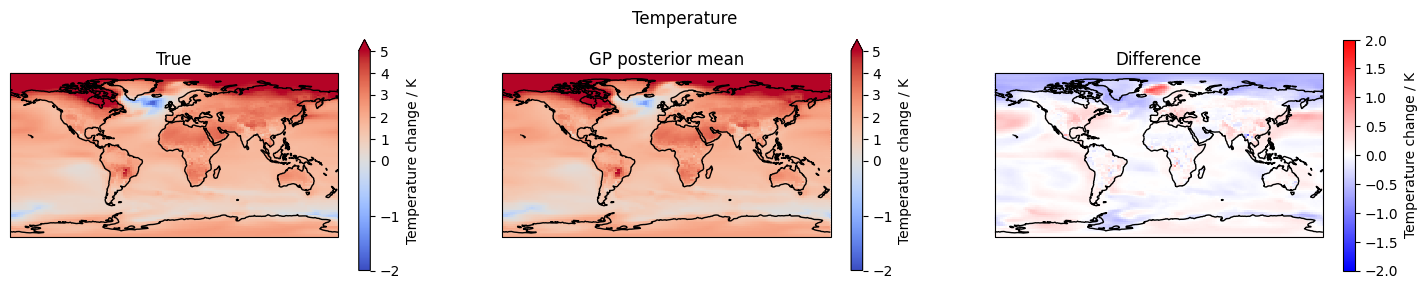

In [14]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Temperature')

# Test
plt.subplot(131, projection=proj)
tas_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                              cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_tas_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", norm=divnorm,
                       cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = tas_truth - posterior_tas_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"Temperature change / K"})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- Mostly CO2
- Really just CO2
- Small noise variance

In [15]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[0.52123]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,8.90851
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,9.565
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.08635
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.7827
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.05491
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.02909, 8.32386, 2.07595..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,1.07922
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[14.49782, 15.26412, 28.76454..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.07666


In [16]:
# Save predictions
posterior_tas_data.to_netcdf('climatebench-gp-posterior-mean-tas-test-2019-2100.nc')
posterior_tas_std_data.to_netcdf('climatebench-gp-posterior-std-tas-test-2019-2100.nc')